<a href="https://colab.research.google.com/github/Jaime-Simoes/TM_Project1/blob/main/Exploration_%26_Processing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from langdetect import detect
import emoji
from collections import Counter
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import AutoTokenizer, AutoModel

#### Load datasets

In [2]:
train_df = pd.read_excel("train.xlsx")
train_reviews_df = pd.read_excel("train_reviews.xlsx")

test_df = pd.read_excel("test.xlsx")
test_reviews_df = pd.read_excel("test_reviews.xlsx")

## 1. Data Exploration

In [3]:
train_df.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [4]:
train_df.shape

(6248, 4)

In [5]:
train_reviews_df.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [6]:
train_reviews_df.shape

(361281, 2)

In [7]:
test_df.head()

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


In [8]:
test_df.shape

(695, 3)

In [9]:
test_reviews_df.head()

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


In [10]:
test_reviews_df.shape

(41866, 2)

### 1.1. Train dataset

#### Check if train dataset is balanced or unbalanced

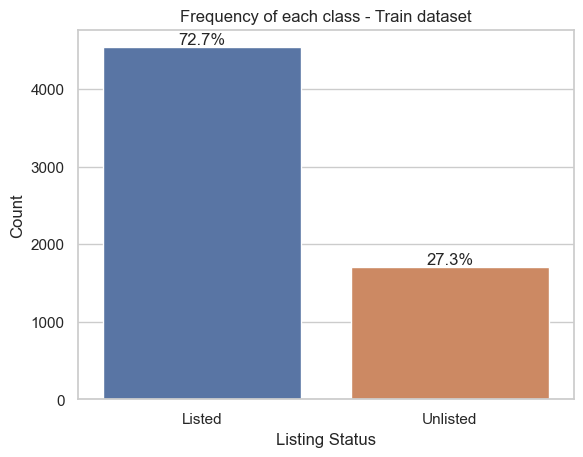

In [11]:
sns.set(style='whitegrid')

label_map = {0: 'Listed', 1: 'Unlisted'}
train_df['count'] = train_df['unlisted'].map(label_map)

# Plot the frequency of each class
ax = sns.countplot(data=train_df, x='count', order=['Listed', 'Unlisted'])

# Percentage
total = len(train_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.xlabel('Listing Status')
plt.ylabel('Count')
plt.title('Frequency of each class - Train dataset')

plt.show()

In the context of predicting Airbnb property unlisting, the observation that the train dataset is unbalanced is crucial for understanding the distribution of the target variable (listing status) and its implications for model training and evaluation.

Our train dataset is unbalanced, meaning that there is a significant disparity in the number of listed and unlisted properties. More precisely,  72.7% of the properties in the dataset are listed, while only 27.3% are unlisted.

#### Check if the index (Airbnb location) is unique

In [12]:
index_range = range(1, 6249)
unique_indices_train = train_df.index.unique()

if len(unique_indices_train) == len(index_range) and set(unique_indices_train) == set(index_range):
    print("Each index appears once and goes from 1 to 6248")

#### Amount of reviews per place

In [13]:
index_values_train_reviews_df = train_reviews_df['index'].value_counts()
print(index_values_train_reviews_df)

# Big difference in comments per property

index
265     891
3396    765
1147    678
4106    617
954     583
       ... 
6092      1
376       1
4480      1
1759      1
6139      1
Name: count, Length: 4245, dtype: int64


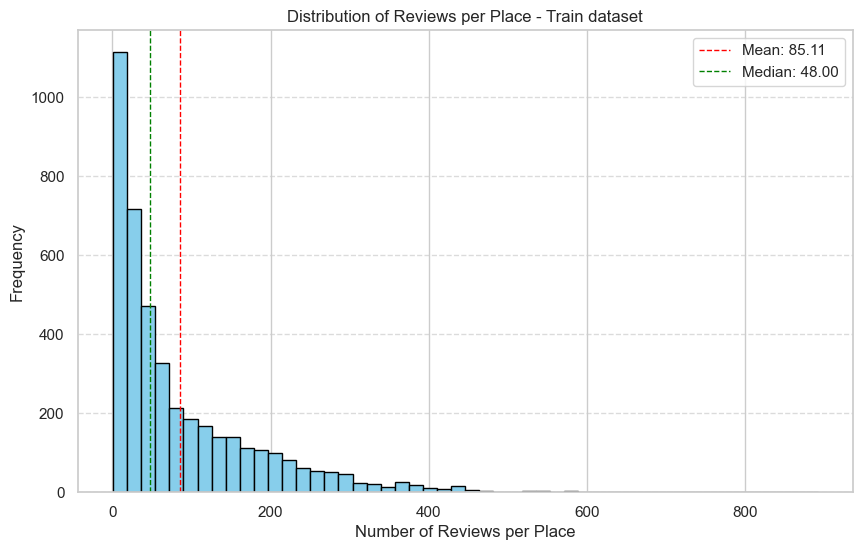

In [14]:
# Calculate the count of reviews per place
review_counts_per_place = train_reviews_df['index'].value_counts()

# Calculate medians
mean_reviews_per_place = review_counts_per_place.mean()
median_reviews_per_place = review_counts_per_place.median()
std_reviews_per_place = review_counts_per_place.std()

# Plot the distribution of reviews per place
plt.figure(figsize=(10, 6))
plt.hist(review_counts_per_place, bins=50, color='skyblue', edgecolor='black')
plt.axvline(mean_reviews_per_place, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_reviews_per_place:.2f}')
plt.axvline(median_reviews_per_place, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_reviews_per_place:.2f}')
plt.xlabel('Number of Reviews per Place')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews per Place - Train dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

It's clear that we have right skewed data, which means we have a notable amount of outliers. This way, we will consider that we have around 48 reviews per place, according to the median.
It would also be good to see if the amount of reviews is similar to the listed and unlisted target variables.

C:\Users\jaime\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


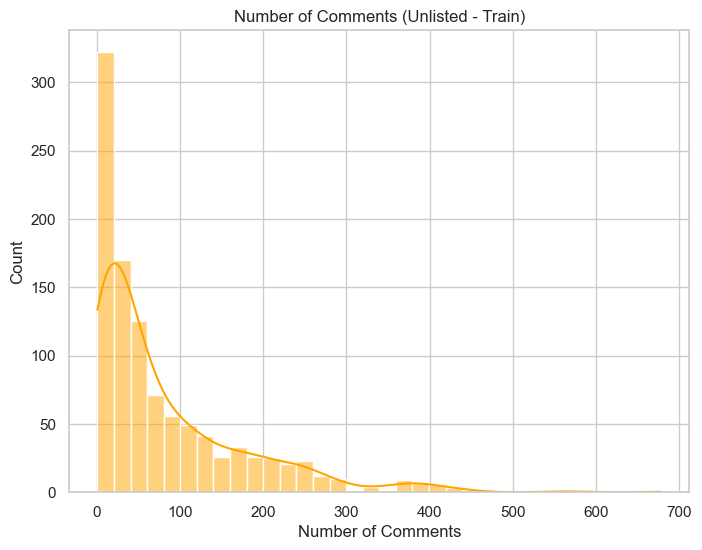

C:\Users\jaime\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


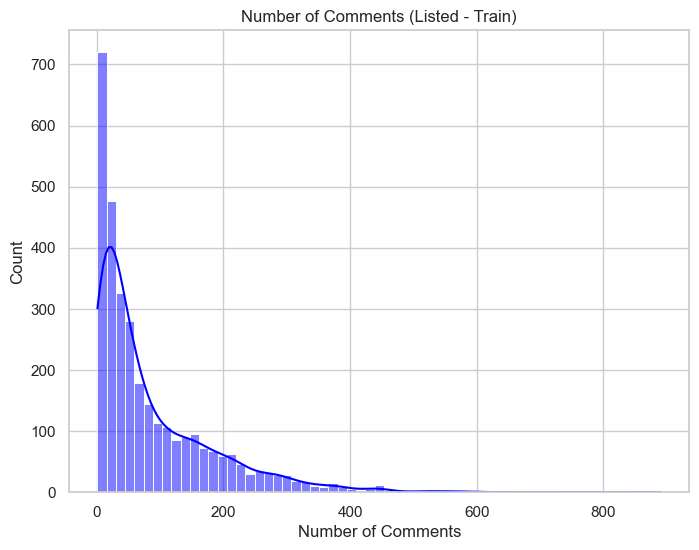

In [15]:
# Calculate the number of comments for each 'index' in the train_reviews_df dataset
comments_count_train = train_reviews_df.groupby('index').count()['comments']

# Merge the train_reviews_df with the train_df based on the index
merged_train_df = train_reviews_df.merge(train_df, left_on='index', right_index=True)

# Filter properties
unlisted_true_train = comments_count_train[merged_train_df['unlisted'] == 1]
unlisted_false_train = comments_count_train[merged_train_df['unlisted'] == 0]

# Plot histograms for "True" and "False"
plt.figure(figsize=(8, 6))
sns.histplot(data=unlisted_true_train, color='orange', kde=True)
plt.xlabel('Number of Comments')
plt.ylabel('Count')
plt.title('Number of Comments (Unlisted - Train)')
plt.show()


plt.figure(figsize=(8, 6))
sns.histplot(data=unlisted_false_train, color='blue', kde=True)
plt.xlabel('Number of Comments')
plt.ylabel('Count')
plt.title('Number of Comments (Listed - Train)')
plt.show()

The listed places have a lot more comments than the unlisted.

### Merging the datasets

In [16]:
# Merging datasets by property so that we only have two datasets. One for training and other for test.
# All comments in a row

train_reviews_df['comments'] = train_reviews_df['comments'].astype(str)
comments_grouped = train_reviews_df.groupby('index')['comments'].apply(lambda x: ' '.join(x)).reset_index()
train_df = train_df.merge(comments_grouped, how='left', on='index')

In [17]:
train_df.head()

,index,description,host_about,unlisted,count,comments
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,Listed,this is a very cozy and comfortable house to s...
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,Unlisted,NaN
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,Unlisted,NaN
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,Listed,NaN
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Listed,Un très bel appartement avec une magnifique vu...


In [18]:
print(train_df['comments'].isna().sum())       # checks out

2003


In [19]:
test_reviews_df['comments'] = test_reviews_df['comments'].astype(str)
test_comments_grouped = test_reviews_df.groupby('index')['comments'].apply(lambda x: ' '.join(x)).reset_index()
test_df = test_df.merge(test_comments_grouped, how='left', on='index')

In [20]:
test_df.head()

,index,description,host_about,comments
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",Thank you very much Antonio ! All has been per...
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,"This is a beautiful, bright apartment in a mor..."
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",NaN
3,4,Charming Apartment Close to the Bay of Cascais...,:),Claudia was a great host. She met us at the t...
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,La maison est exactement comme sur les photos....


At this point we have only two datasets: "train_df" and "test_df".

#### Places that don't have reviews

In [21]:
missing_indexes_train = set(range(1, 6249)) - set(index_values_train_reviews_df.index)
amount_missing = len(missing_indexes_train)      # amount of places with no review

print("Places that don't have reviews:", amount_missing)
print(missing_indexes_train)

Places that don't have reviews: 2003
{2, 3, 4, 6, 7, 13, 15, 17, 18, 21, 22, 28, 34, 41, 46, 48, 50, 52, 57, 60, 64, 67, 72, 74, 75, 77, 82, 84, 85, 87, 89, 92, 93, 94, 95, 96, 102, 103, 104, 108, 114, 115, 117, 118, 121, 125, 132, 135, 136, 138, 139, 143, 151, 157, 158, 160, 166, 170, 176, 178, 180, 186, 187, 189, 191, 200, 202, 206, 209, 213, 215, 216, 228, 231, 234, 236, 237, 239, 240, 252, 255, 256, 258, 260, 261, 263, 264, 266, 267, 268, 271, 276, 281, 284, 286, 288, 296, 297, 299, 302, 304, 306, 308, 316, 323, 324, 335, 343, 349, 362, 363, 364, 372, 379, 380, 383, 385, 387, 393, 397, 401, 402, 403, 410, 422, 434, 438, 443, 447, 450, 451, 455, 457, 460, 463, 469, 473, 476, 477, 478, 481, 482, 483, 485, 488, 489, 491, 492, 502, 506, 512, 513, 516, 522, 525, 533, 541, 543, 544, 546, 548, 556, 561, 562, 563, 571, 574, 580, 582, 587, 588, 594, 600, 605, 610, 615, 621, 625, 627, 628, 629, 630, 633, 635, 637, 638, 646, 647, 654, 655, 656, 657, 662, 666, 667, 669, 670, 676, 677, 678, 686

##### >> Percentage of places with no reviews (very high)

In [22]:
(amount_missing / 6248) * 100

32.058258642765686

### 1.2. Test dataset

#### Check if the index (Airbnb location) is unique

In [23]:
# Count the occurrences of each index
index_values_test_df = test_df.index.value_counts()
print(index_values_test_df)

0      1
467    1
459    1
460    1
461    1
      ..
233    1
234    1
235    1
236    1
694    1
Name: count, Length: 695, dtype: int64


In [24]:
if test_df.index.is_unique:
    print("The index values are unique for all entries.")
else:
    print("The index values are not unique for all entries.")

The index values are unique for all entries.


#### Amount of reviews per place

In [25]:
index_values_test_reviews_df = test_reviews_df['index'].value_counts()
print(index_values_test_reviews_df)

index
160    649
129    571
435    522
418    489
387    461
      ... 
138      1
141      1
38       1
83       1
453      1
Name: count, Length: 475, dtype: int64


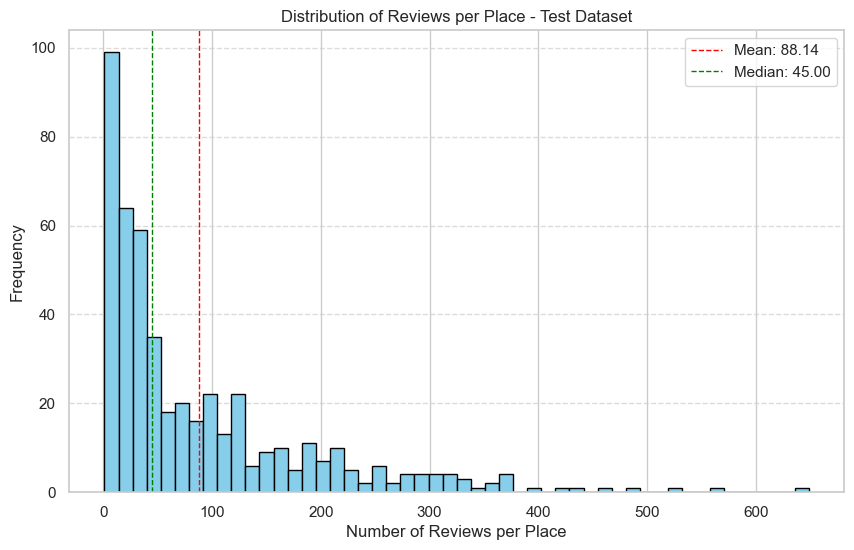

In [26]:
# Doing the same visualization for test reviews
review_counts_per_place = test_reviews_df['index'].value_counts()

mean_reviews_per_place = review_counts_per_place.mean()
median_reviews_per_place = review_counts_per_place.median()
std_reviews_per_place = review_counts_per_place.std()

# Plot the distribution of reviews per place
plt.figure(figsize=(10, 6))
plt.hist(review_counts_per_place, bins=50, color='skyblue', edgecolor='black')
plt.axvline(mean_reviews_per_place, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_reviews_per_place:.2f}')
plt.axvline(median_reviews_per_place, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_reviews_per_place:.2f}')
plt.xlabel('Number of Reviews per Place')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews per Place - Test Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

#### Places that don't have reviews

In [27]:
# Get the places that don't have reviews

missing_indexes_test = set(range(1, 695)) - set(index_values_test_reviews_df.index)
amount_missing_test = len(missing_indexes_test)     

print("Places that don't have reviews:", amount_missing_test)

Places that don't have reviews: 220


##### >> Percentage of places with no reviews (very high)

In [28]:
(amount_missing_test / 695) * 100      # also high

31.654676258992804

The percentage of places that don't have reviews is the same for training and testing. Since we can't change test set we need to also include in the model these situations so, we can not delete these rows. 1/3 of predictions will be on no comments.

### 1.3. Duplicated records

In [29]:
train_duplicates = train_df.duplicated().sum()

test_duplicates = test_df.duplicated().sum()

print("Duplicate records in train dataset:", train_duplicates)
print("Duplicate records in test dataset:", test_duplicates)

Duplicate records in train dataset: 0
Duplicate records in test dataset: 0


#### Duplicated records handling

In this process, we identified and merged duplicated property records in the train and test datasets, creating a new unique index for each unique property. We then mapped these new indexes to corresponding reviews in the train reviews and test reviews datasets, ensuring accurate association. Finally, duplicates were removed from the training set, and the old index column was dropped.

In [30]:
mapping = train_df.groupby(['description', 'host_about', 'unlisted']).ngroup()

train_reviews_df['index'] = train_reviews_df['index'].map(mapping.to_dict())

train_df.set_index(mapping.values, inplace = True)

train_df.drop_duplicates(inplace = True)

### 1.4. Variables analyses

#### 1.4.1. Description

#### For train dataset

In [31]:
num_unique_descriptions_train = len(train_df['description'].unique())
print("Number of unique descriptions in train dataset:", num_unique_descriptions_train)

Number of unique descriptions in train dataset: 6023


In [33]:
# Get the top 5 most common descriptions and their counts
top_desc_train = train_df['description'].value_counts().head()

top_desc_df = top_desc_train.reset_index()
top_desc_df.columns = ['Description', 'Count']

print(top_desc_df)

                                         Description  Count
0                  <b>License number</b><br />Exempt     19
1  Set in a stunning seaside location, this luxur...      6
2  We are The Salty Pelican Yoga & Surf Retreat. ...      6
3  Set in a stunning seaside location, this luxur...      5
4  Located in Chiado district, one of the trendie...      5


#### For test dataset

In [34]:
num_unique_descriptions_test = len(test_df['description'].unique())
print("Number of unique descriptions in test dataset:", num_unique_descriptions_test)

Number of unique descriptions in test dataset: 691


In [35]:
# For test set
top_desc_test = test_df['description'].value_counts().head()

top_desc_test_ = top_desc_test.reset_index()
top_desc_test_.columns = ['Description', 'Count']

print(top_desc_test_)

                                         Description  Count
0  Nesha Guesthouse Lisbon is a surf & beach orie...      2
1  <b>The space</b><br />Lisbon Nouveau apartment...      2
2  This unique apartment, with an incredible view...      2
3  Book now a bed, at Impact House Belém, a hoste...      2
4  <b>The space</b><br />Apartment located in the...      1


#### 1.4.2. Host_about

#### For train dataset

In [36]:
num_unique_host_about_train = len(train_df['host_about'].unique())
print("Number of unique host_about in train dataset:", num_unique_host_about_train)

Number of unique host_about in train dataset: 2803


In [37]:
# Get the top 5 most common host_about
top_common_host_about_train = train_df['host_about'].value_counts().head()

top_common_host_about_df = top_common_host_about_train.reset_index()
top_common_host_about_columns = ['host_about', 'Count']

print(top_common_host_about_df)

                                          host_about  count
0  We are Feels Like Home Holiday Rentals.\nA com...    153
1  Dear guest.\n\nWe take pride in helping thousa...     93
2  Founded by travel enthusiasts (just like you) ...     66
3  Hi there!\n\nWe're GuestReady, a professional ...     62
4  Hi, we are Homing - a company that develops it...     43


In [38]:
train_df.head()

,index,description,host_about,unlisted,count,comments
5271,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,Listed,this is a very cozy and comfortable house to s...
3630,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,Unlisted,NaN
5453,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,Unlisted,NaN
814,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,Listed,NaN
2850,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Listed,Un très bel appartement avec une magnifique vu...


#### For test dataset

In [39]:
num_unique_host_about_test = len(test_df['host_about'].unique())
print("Number of unique host_about in test dataset:", num_unique_host_about_test)

Number of unique host_about in test dataset: 550


In [40]:
# Get the top 5 most common host_about
top_common_host_about_test = test_df['host_about'].value_counts().head()

top_common_host_about_df = top_common_host_about_test.reset_index()
top_common_host_about_df.columns = ['host_about', 'Count']

print(top_common_host_about_df)

                                          host_about  Count
0  We are Feels Like Home Holiday Rentals.\nA com...     14
1  Dear guest.\n\nWe take pride in helping thousa...     14
2  Hello! We are Camila and Paulo! Parents of tri...      6
3  Hi there!\n\nWe're GuestReady, a professional ...      5
4  Hi there!\n\nWe're GuestReady, a professional ...      5


#### 1.4.3. Comments

In [41]:
# Get the top 5 most common comments
top_common_comments_train = train_reviews_df['comments'].value_counts().head()

top_common_comments_df = top_common_comments_train.reset_index()
top_common_comments_columns = ['comments', 'Count']

print(top_common_comments_df)

          comments  count
0                .    449
1  Great location!    131
2   Great location    123
3     Great place!    110
4      Great place     96


In [42]:
# Get the top 5 most common comments (test)
top_common_comments_test = test_reviews_df['comments'].value_counts().head()

top_common_comments_df = top_common_comments_test.reset_index()
top_common_comments_columns = ['comments', 'Count']

print(top_common_comments_df)

          comments  count
0                .     69
1  Great location!     23
2     Great place!     15
3      Great place     14
4   Great location     13


### 1.5. Missing values

#### 1.5.1. Description

In [43]:
# Count missing values in the 'description' column
missing_description_count = train_df['description'].isnull().sum()

print("Missing values in 'description' column:", missing_description_count)

Missing values in 'description' column: 0


In [44]:
# For test set
missing_description_count = test_df['description'].isnull().sum()

print("Missing values in 'description' column:", missing_description_count)

Missing values in 'description' column: 0


We already saw that we have 19 entries saying " <b>License number</b><br />Exempt ". This entry can be seen as a missing value because it doesn't provide any information, it's probably just a default description. For entries that start with that expression, or that have less than 17 characters before the appearance of that expression, we will consider it an empty string.

In [45]:
# Replace "<b>License number</b>" with an empty string
train_df.loc[train_df['description'].str.startswith('<b>License number</b>'), 'description'] = ''

In [46]:
# Define a regular expression pattern to match observations ending with "License Number"
pattern = r'^.{0,17}License Number$'  

# Replace matching entries with an empty string
train_df['description'] = train_df['description'].str.replace(pattern, '', regex=True)

In [47]:
test_df.loc[test_df['description'].str.startswith('<b>License number</b>'), 'description'] = ''

In [48]:
# Define a regular expression pattern to match observations ending with "License Number"
pattern = r'^.{0,17}License Number$'  

# Same for test
test_df['description'] = test_df['description'].str.replace(pattern, '', regex=True)

#### 1.5.1. Host_about

In [49]:
# Count missing values in the 'host_about' column
missing_host_about_count = train_df['host_about'].isnull().sum()

print("Missing values in 'host_about' column:", missing_host_about_count)

Missing values in 'host_about' column: 0


In [50]:
missing_host_about_count_test = test_df['host_about'].isnull().sum()
print("Missing values in 'host_about' column in test_df:", missing_host_about_count_test)

Missing values in 'host_about' column in test_df: 0


In the host_about variable we have some entries containing weird characters. These expressions will be removed in the section "Punctuation" in the Preprocessing.

In [51]:
missing_markers = ['', '.', '...', ':)', '-', '_', ':-)', '_x000D_', '_x000D__x000D_', '_x000D__x000D__x000D__x000D__x000D__x000D__x000D__x000D_', '@ZMPoppe', 'None', '_x000D_\n', np.nan, '\n', '!']

missing_values_host_about = train_df['host_about'].isin(missing_markers).sum()

print("Missing values in 'host_about' column:", missing_values_host_about)

Missing values in 'host_about' column: 46


### 1.6. Languages

Here we are adding a column to each one of our datasets where we say the language used in each one of the records.

In [52]:
#!pip install langdetect

In [53]:
# Function to detect language
def language_detection(x):
    try:
        return detect(x)
    except:
        return 'error'

# Apply the function
train_df['language'] = train_df['description'].apply(lambda x: language_detection(str(x)))
test_df['language'] = test_df['description'].apply(lambda x: language_detection(str(x)))

# Verification
print("First few rows of train_df with 'language' column:")
print(train_df.head())

print("\nFirst few rows of test_df with 'language' column:")
print(test_df.head())

First few rows of train_df with 'language' column:
      index                                        description  \
5271      1  This is a shared mixed room in our hostel, wit...   
3630      2  O meu espaço fica perto de Parque Eduardo VII,...   
5453      3  Trafaria’s House is a cozy and familiar villa ...   
814       4  Apartamento Charmoso no Chiado, Entre o Largo ...   
2850      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                             host_about  unlisted     count  \
5271                Alojamento Local Registro: 20835/AL         0    Listed   
3630  I am friendly host, and I will try to always b...         1  Unlisted   
5453  I am a social person liking to communicate, re...         1  Unlisted   
814   Hello!_x000D_\nI m Portuguese and i love to me...         0    Listed   
2850  Nous sommes une famille avec deux enfants de 1...         0    Listed   

                                               comments language  
5271  this

In [54]:
# Get ratios of languages for both datasets

train_lang_counts = train_df['language'].value_counts(normalize=True) * 100
test_lang_counts = test_df['language'].value_counts(normalize=True) * 100

# percentages
print("Percentage of each language in train_df:")
print(train_lang_counts)

print("\nPercentage of each language in test_df:")
print(test_lang_counts)

Percentage of each language in train_df:
language
en       81.241997
pt       14.436620
error     1.392446
fr        1.344430
de        0.720230
es        0.432138
da        0.160051
no        0.064020
it        0.048015
ca        0.048015
zh-cn     0.048015
sv        0.032010
nl        0.032010
Name: proportion, dtype: float64

Percentage of each language in test_df:
language
en       82.877698
pt       13.669065
error     1.438849
fr        0.863309
da        0.431655
de        0.287770
es        0.287770
ca        0.143885
Name: proportion, dtype: float64


We have identified several languages in the train dataset. English is the most common, around 81.6% of both datasets. Portuguese follows, representing approximately 14%. Other languages include French, Danish, and German, each comprising less than 2% of the dataset. The remaining languages such as Spanish, Norwegian, Catalan, Chinese, Italian, Dutch, and Swedish have a combined presence of less than 1%.

### 1.7. World Cloud

In [55]:
# Calculate word count for training

train_df['description_word_count'] = train_df['description'].apply(lambda x: len(str(x).split(" ")))
train_df['host_about_word_count'] = train_df['host_about'].apply(lambda x: len(str(x).split(" ")))
train_df['comments_word_count'] = train_df['comments'].apply(lambda x: len(str(x).split(" ")))

In [56]:
train_df.head()

,index,description,host_about,unlisted,count,comments,language,description_word_count,host_about_word_count,comments_word_count
5271,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,Listed,this is a very cozy and comfortable house to s...,en,127,4,1331
3630,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,Unlisted,NaN,pt,23,24,1
5453,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,Unlisted,NaN,en,170,45,1
814,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,Listed,NaN,pt,47,31,1
2850,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Listed,Un très bel appartement avec une magnifique vu...,fr,101,37,1064


In [57]:
train_df.description_word_count.describe()

count    6248.000000
mean      132.832907
std        48.160638
min         1.000000
25%        99.000000
50%       157.000000
75%       167.000000
max       210.000000
Name: description_word_count, dtype: float64

In [58]:
train_df.host_about_word_count.describe()

count    6248.000000
mean       73.653009
std        79.660191
min         1.000000
25%        26.000000
50%        55.000000
75%       101.000000
max      1387.000000
Name: host_about_word_count, dtype: float64

In [59]:
train_df.comments_word_count.describe()

count     6248.000000
mean      2774.291773
std       4530.494404
min          1.000000
25%          1.000000
50%        787.000000
75%       3497.000000
max      46976.000000
Name: comments_word_count, dtype: float64

In [60]:
# Get most frequent 'words' for all three columns

# Convert each description to string
description_words = ' '.join(train_df['description'].apply(str)).split()
description_freq = pd.Series(description_words).value_counts()
top_10_description_words = description_freq.head(10)

# Convert each host_about to string
host_about_words = ' '.join(train_df['host_about'].apply(str)).split()
host_about_freq = pd.Series(host_about_words).value_counts()
top_10_host_about_words = host_about_freq.head(10)

# Convert each comment to string
comments_words = ' '.join(train_df['comments'].apply(str)).split()
comments_freq = pd.Series(comments_words).value_counts()
top_10_comments_words = comments_freq.head(10)

print("Top 10 most frequent words in the 'description' column:")
print(top_10_description_words)
print("\nTop 10 most frequent words in the 'host_about' column:")
print(top_10_host_about_words)
print("\nTop 10 most frequent words in the 'comments' column:")
print(top_10_comments_words)

Top 10 most frequent words in the 'description' column:
the      31323
and      27698
a        25540
/><br    17380
to       15328
of       15122
in       13866
with     13649
is       12083
de        6918
Name: count, dtype: int64

Top 10 most frequent words in the 'host_about' column:
and    16358
to     13291
the    10797
a      10535
in      9860
of      6524
I       6419
you     6248
de      4325
We      4206
Name: count, dtype: int64

Top 10 most frequent words in the 'comments' column:
and     553157
the     515963
a       398631
to      328675
is      258191
in      249469
was     239807
of      174087
very    156654
The     143987
Name: count, dtype: int64


The most frequent words are "stop words".

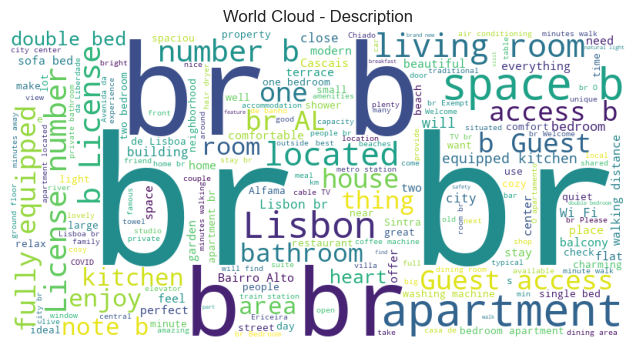

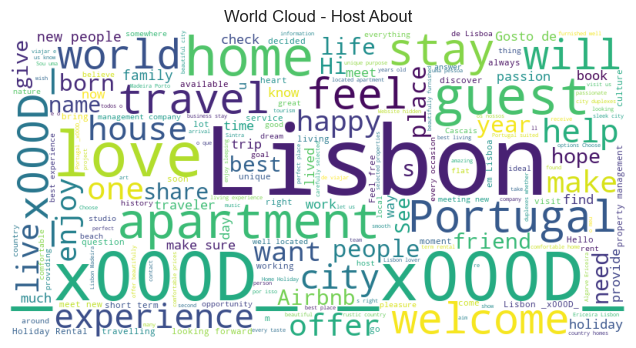

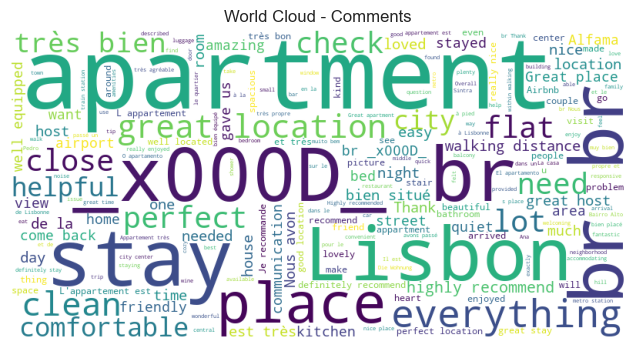

In [61]:
def wordcloud(column, title):

    text = ' '.join(map(str, column))

    # Create WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    # Plotting for each column
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

wordcloud(train_df['description'], 'World Cloud - Description')
wordcloud(train_df['host_about'], 'World Cloud - Host About')
wordcloud(train_df['comments'], 'World Cloud - Comments')

>>>> Making new datasets for savety

In [62]:
train_df_2 = train_df.copy()
test_df_2 = test_df.copy()

## 2. Data Preprocessing

#### Remove HTML tags and special characters
HTML (Hypertext Markup Language) is the standard language for creating web pages. It uses tags enclosed in angle brackets to structure content. When cleaning text data, removing HTML tags involves stripping these elements to obtain the raw text content. Also, removing special characters is a common step in text preprocessing because they often do not add meaningful information. Special characters such as punctuation marks and symbols can introduce noise.

In [63]:
# First we will delete the html and the skip lins(\n) codes
def clean_text(text):
    if isinstance(text, str):
        
        text = re.sub(r'<[^>]*>', ' ', text)
        text = re.sub(r'<br\s*/?>', ' ', text)
        text = re.sub(r'_x000D_', '', text)
        text = re.sub(r'\n',' ',text)
        
    return text

In [64]:
columns_to_clean_train = ["description", "host_about", "comments"]

for column in columns_to_clean_train:
    train_df_2[column] = train_df_2[column].apply(clean_text)

columns_to_clean_test = ["description", "host_about", "comments"]

for column in columns_to_clean_test:
    test_df_2[column] = test_df_2[column].apply(clean_text)

In [65]:
train_df_2.head()

,index,description,host_about,unlisted,count,comments,language,description_word_count,host_about_word_count,comments_word_count
5271,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,Listed,this is a very cozy and comfortable house to s...,en,127,4,1331
3630,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,Unlisted,NaN,pt,23,24,1
5453,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,Unlisted,NaN,en,170,45,1
814,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello! I m Portuguese and i love to meet peopl...,0,Listed,NaN,pt,47,31,1
2850,5,Joli appartement en bordure de mer. 2 min. a...,Nous sommes une famille avec deux enfants de 1...,0,Listed,Un très bel appartement avec une magnifique vu...,fr,101,37,1064


In [66]:
test_df_2.head()

,index,description,host_about,comments,language
0,1,The space Apartment located in the historic ...,"Gosto de viajar, de conhecer pessoas, gosto de...",Thank you very much Antonio ! All has been per...,en
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team! You can count on us ...,"This is a beautiful, bright apartment in a mor...",en
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there! We're GuestReady, a professional pr...",NaN,en
3,4,Charming Apartment Close to the Bay of Cascais...,:),Claudia was a great host. She met us at the t...,en
4,5,"Se procura umas férias perto da praia, casino ...","Bem vindos a Portugal! Adoro o meu País, mas t...",La maison est exactement comme sur les photos....,pt


### Lower case

In [67]:
def lower_text_columns(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: x.lower() if isinstance(x, str) else x)
    return df

In [68]:
columns = ['description', 'host_about', 'comments']

train_df_2 = lower_text_columns(train_df_2, columns)
test_df_2 = lower_text_columns(test_df_2, columns)

In [69]:
train_df_2.head()

,index,description,host_about,unlisted,count,comments,language,description_word_count,host_about_word_count,comments_word_count
5271,1,"this is a shared mixed room in our hostel, wit...",alojamento local registro: 20835/al,0,Listed,this is a very cozy and comfortable house to s...,en,127,4,1331
3630,2,"o meu espaço fica perto de parque eduardo vii,...","i am friendly host, and i will try to always b...",1,Unlisted,NaN,pt,23,24,1
5453,3,trafaria’s house is a cozy and familiar villa ...,"i am a social person liking to communicate, re...",1,Unlisted,NaN,en,170,45,1
814,4,"apartamento charmoso no chiado, entre o largo ...",hello! i m portuguese and i love to meet peopl...,0,Listed,NaN,pt,47,31,1
2850,5,joli appartement en bordure de mer. 2 min. a...,nous sommes une famille avec deux enfants de 1...,0,Listed,un très bel appartement avec une magnifique vu...,fr,101,37,1064


In [70]:
test_df_2.head()

,index,description,host_about,comments,language
0,1,the space apartment located in the historic ...,"gosto de viajar, de conhecer pessoas, gosto de...",thank you very much antonio ! all has been per...,en
1,2,"important: in response to covid-19, this prope...",we are the be@home team! you can count on us ...,"this is a beautiful, bright apartment in a mor...",en
2,3,"bright, beautiful, and spacious. this four-bed...","hi there! we're guestready, a professional pr...",NaN,en
3,4,charming apartment close to the bay of cascais...,:),claudia was a great host. she met us at the t...,en
4,5,"se procura umas férias perto da praia, casino ...","bem vindos a portugal! adoro o meu país, mas t...",la maison est exactement comme sur les photos....,pt


### Expanding contractions

In [71]:
contractions_dict = {
    # English contractions
    "ain't": "are not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "m":"am",
    "ma'am": "madam",
    "might've": "might have",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there'd": "there would",
    "there'll": "there will",
    "there're": "there are",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "y'all": "you all",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",

    # French contractions
    "c'est": "ce est",
    "qu'il": "que il",
    "n'est": "ne est",
    "l'a": "la a",
    "j'ai": "je ai",
    "d'un": "de un",
    "s'est": "se est",

    # Spanish contractions
    "d'el": "de el",
    "al": "a el",
    "del": "de el",
    "como": "cómo",
    "según": "según",
    "está": "esta",
    "esos": "esos",

    # Portuguese contractions
    "da": "de a",
    "das": "de as",
    "do": "de o",
    "dos": "de os",
    "na": "em a",
    "nas": "em as",
    "no": "em o",
    "nos": "em os",
}
def expand_contractions(text, contractions_dict):
    words = text.split()
    expanded_words = [contractions_dict.get(word, word) for word in words]
    return ' '.join(expanded_words)
def split_words(text):
    return text.split()


In [72]:
columns = ['description', 'host_about', 'comments']
for column in columns:
    test_df_2[column] = test_df_2[column].apply(lambda x: expand_contractions(x, contractions_dict) if isinstance(x, str) else x)
    test_df_2[column] = test_df_2[column].apply(lambda x: split_words(x) if isinstance(x, str) else x)

In [73]:
test_df_2.head()

,index,description,host_about,comments,language
0,1,"[the, space, apartment, located, in, the, hist...","[gosto, de, viajar,, de, conhecer, pessoas,, g...","[thank, you, very, much, antonio, !, all, has,...",en
1,2,"[important:, in, response, to, covid-19,, this...","[we, are, the, be@home, team!, you, can, count...","[this, is, a, beautiful,, bright, apartment, i...",en
2,3,"[bright,, beautiful,, and, spacious., this, fo...","[hi, there!, we, are, guestready,, a, professi...",NaN,en
3,4,"[charming, apartment, close, to, the, bay, of,...",[:)],"[claudia, was, a, great, host., she, met, us, ...",en
4,5,"[se, procura, umas, férias, perto, de, a, prai...","[bem, vindos, a, portugal!, adoro, o, meu, paí...","[la, maison, est, exactement, comme, sur, les,...",pt


In [74]:
for column in columns:
    train_df_2[column] = train_df_2[column].apply(lambda x: expand_contractions(x, contractions_dict) if isinstance(x, str) else x)
    train_df_2[column] = train_df_2[column].apply(lambda x: split_words(x) if isinstance(x, str) else x)

In [75]:
train_df_2.head()

,index,description,host_about,unlisted,count,comments,language,description_word_count,host_about_word_count,comments_word_count
5271,1,"[this, is, a, shared, mixed, room, in, our, ho...","[alojamento, local, registro:, 20835/al]",0,Listed,"[this, is, a, very, cozy, and, comfortable, ho...",en,127,4,1331
3630,2,"[o, meu, espaço, fica, perto, de, parque, edua...","[i, am, friendly, host,, and, i, will, try, to...",1,Unlisted,NaN,pt,23,24,1
5453,3,"[trafaria’s, house, is, a, cozy, and, familiar...","[i, am, a, social, person, liking, to, communi...",1,Unlisted,NaN,en,170,45,1
814,4,"[apartamento, charmoso, em, o, chiado,, entre,...","[hello!, i, am, portuguese, and, i, love, to, ...",0,Listed,NaN,pt,47,31,1
2850,5,"[joli, appartement, en, bordure, de, mer., 2, ...","[nous, sommes, une, famille, avec, deux, enfan...",0,Listed,"[un, très, bel, appartement, avec, une, magnif...",fr,101,37,1064


### Stop words

In [76]:
# Define stop words for each language
stop_words = {
    "en": set(stopwords.words('english')),
    "pt": set(stopwords.words('portuguese')),
    "fr": set(stopwords.words('french')),
    "da": set(stopwords.words('danish')),
    "de": set(stopwords.words('german')),
    "es": set(stopwords.words('spanish')),
    "no": set(stopwords.words('norwegian')),
    "ca": set(stopwords.words('catalan')),
    "zh-cn": set(stopwords.words('chinese')),
    "it": set(stopwords.words('italian')),
    "nl": set(stopwords.words('dutch')),
    "sv": set(stopwords.words('swedish'))
}

# Function to remove stop words based on language
def remove_stop_words(word_list, language):
    stop = stop_words.get(language, None)
    if stop and isinstance(word_list,list):
        return [word for word in word_list if word not in stop]
    else:
        return word_list


In [77]:
columns_to_normalize = ['description', 'host_about', 'comments']
for column in columns_to_normalize:
    train_df_2[column] = train_df_2.apply(lambda x: remove_stop_words(x[column], x['language']), axis=1)
    test_df_2[column] = test_df_2.apply(lambda x: remove_stop_words(x[column], x['language']), axis=1)

In [78]:
train_df_2.head()

,index,description,host_about,unlisted,count,comments,language,description_word_count,host_about_word_count,comments_word_count
5271,1,"[shared, mixed, room, hostel,, shared, bathroo...","[alojamento, local, registro:, 20835/al]",0,Listed,"[cozy, comfortable, house, stay, in.never, wor...",en,127,4,1331
3630,2,"[espaço, fica, perto, parque, eduardo, vii,, s...","[i, am, friendly, host,, and, i, will, try, to...",1,Unlisted,NaN,pt,23,24,1
5453,3,"[trafaria’s, house, cozy, familiar, villa, fac...","[social, person, liking, communicate,, reading...",1,Unlisted,NaN,en,170,45,1
814,4,"[apartamento, charmoso, chiado,, largo, carmo,...","[hello!, i, am, portuguese, and, i, love, to, ...",0,Listed,NaN,pt,47,31,1
2850,5,"[joli, appartement, bordure, mer., 2, min., a,...","[famille, deux, enfants, 17, 10, ans., habité,...",0,Listed,"[très, bel, appartement, magnifique, vue, plag...",fr,101,37,1064


In this step we are removing common stopwords across multiple languages using the Natural Language Toolkit (NLTK) library.

### Regular Expressions

In [79]:
def regular_currency(text):
    regular_text = re.sub(r'[$€£]\d+(\.\d+)?', '#COST', text)
    regular_text = re.sub(r'\b\d+\s?(USD|EUR|GBP)\b', '#COST', text)
    regular_text = re.sub(r'\b\d+\s?(dollars|euros|pounds)\b', '#COST', text)
    return regular_text

def regular_dates(text):
    regular_text = re.sub(r'(\d{1,2})/(\d{1,2})/(\d{4})', r'\3-\1-\2', text)
    regular_text = re.sub(r'(\d{4})-(\d{1,2})-(\d{1,2})', r'\3/\2/\1', text)
    return regular_text

def regular_measurements(text):
    regular_text = re.sub(r'\bm(eters)?\b', 'meter', text)
    regular_text = re.sub(r'\b(km|kilometers)\b', 'kilometer', text)
    regular_text = re.sub(r'\b(miles|mi)\b', 'mile', text)
    return regular_text

def regular_abbreviations(text):
    abbreviations = {
        'USA': 'united states of america',
        'UK': 'united kingdom',
        'US': 'united states',
        'EU': 'european union',
    }
    for abbreviation, full_form in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(abbreviation), full_form, text)
    return text

def regular_email_addresses(text):
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    regular_text = re.sub(email_pattern, 'email', text)
    return regular_text

def regular_web_links(text):
    url_pattern = r'http\S+|www\S+'
    regular_text = re.sub(url_pattern, 'url', text)
    return regular_text

def regular_spelling(text):
    spelling_variations = {
        'colour': 'color',
        'favourite': 'favorite',
        'centre': 'center',
        'travelling': 'traveling',
        'organisation': 'organization',
        'recognise': 'recognize',
        'cheque': 'check',
        'catalogue': 'catalog',
        'neighbour': 'neighbor',
    }
    for misspelling, correct_spelling in spelling_variations.items():
        text = re.sub(r'\b{}\b'.format(misspelling), correct_spelling, text)
    return text

def normalize_text(text):
    if isinstance(text, list):
        return [normalize_text(element) for element in text]
    if isinstance(text, str):
        text = regular_currency(text)
        text = regular_dates(text)
        text = regular_measurements(text)
        text = regular_abbreviations(text)
        text = regular_email_addresses(text)
        text = regular_web_links(text)
        text = regular_spelling(text)
    return text

def apply_normalization(df):
    for column in df.columns:
        df[column] = df[column].apply(normalize_text)
    return df

In [80]:
columns_to_normalize = ['description', 'host_about', 'comments']
for column in columns_to_normalize:
    train_df_2[column] = train_df_2[column].apply(normalize_text)
    test_df_2[column] = test_df_2[column].apply(normalize_text)

### Punctuation

In [81]:
def remove_punctuation(text):
    if isinstance(text, list):
        return [re.sub(r'[^\w\s]', '', word) if isinstance(word, str) else word for word in text]
    else:
        return text

In [82]:
def applying(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(remove_punctuation)
    return df


In [83]:
train_df_2 = applying(train_df_2)
test_df_2 = applying(test_df_2)

In [84]:
test_df_2.head()

,index,description,host_about,comments,language
0,1,"[space, apartment, located, historic, center, ...","[gosto, de, viajar, de, conhecer, pessoas, gos...","[thank, much, antonio, , perfect, stay, appart...",en
1,2,"[important, response, covid19, property, exten...","[behome, team, count, us, take, care, every, s...","[beautiful, bright, apartment, residential, ar...",en
2,3,"[bright, beautiful, spacious, fourbedroom, apa...","[hi, there, guestready, professional, property...",NaN,en
3,4,"[charming, apartment, close, bay, cascais, 1, ...",[],"[claudia, great, host, met, us, train, station...",en
4,5,"[procura, umas, férias, perto, praia, casino, ...","[bem, vindos, portugal, adoro, país, adoro, co...","[la, maison, est, exactement, comme, sur, les,...",pt


In [85]:
train_df_2.head()

,index,description,host_about,unlisted,count,comments,language,description_word_count,host_about_word_count,comments_word_count
5271,1,"[shared, mixed, room, hostel, shared, bathroom...","[alojamento, local, registro, 20835al]",0,Listed,"[cozy, comfortable, house, stay, innever, worr...",en,127,4,1331
3630,2,"[espaço, fica, perto, parque, eduardo, vii, sa...","[i, am, friendly, host, and, i, will, try, to,...",1,Unlisted,NaN,pt,23,24,1
5453,3,"[trafarias, house, cozy, familiar, villa, faci...","[social, person, liking, communicate, reading,...",1,Unlisted,NaN,en,170,45,1
814,4,"[apartamento, charmoso, chiado, largo, carmo, ...","[hello, i, am, portuguese, and, i, love, to, m...",0,Listed,NaN,pt,47,31,1
2850,5,"[joli, appartement, bordure, mer, 2, min, a, p...","[famille, deux, enfants, 17, 10, ans, habité, ...",0,Listed,"[très, bel, appartement, magnifique, vue, plag...",fr,101,37,1064


### Stemming and lemmatization

Stemming is chosen over lemmatization due to the complexity involved in handling multiple languages. Stemming is simpler and can still provide meaningful results for many natural language processing tasks, making it a more practical choice when dealing with multilingual datasets.

In [86]:
stemmers = {
    'english': SnowballStemmer('english'),
    'portuguese': SnowballStemmer('portuguese'),
    'italian': SnowballStemmer('italian'),
    'spanish': SnowballStemmer('spanish'),
    'french': SnowballStemmer('french'),
    'german': SnowballStemmer('german'),
    'russian': SnowballStemmer('russian'),
    'dutch': SnowballStemmer('dutch'),
    'swedish': SnowballStemmer('swedish'),
    'norwegian': SnowballStemmer('norwegian'),
    'danish': SnowballStemmer('danish')
}

columns = ["description", "host_about", "comments"]

for index, row in train_df_2.iterrows():
    lang = row['language']
    if lang in stemmers:
        for column in columns:
            # Apply stemming
            row[column] = [stemmers[lang].stem(word) if len(word) > 1 else word for word in row[column]] if isinstance(row[column], list) else row[column]

for index, row in test_df_2.iterrows():
    lang = row['language']
    if lang in stemmers:
        for column in columns:
            # Apply stemming
            row[column] = [stemmers[lang].stem(word) if len(word) > 1 else word for word in row[column]] if isinstance(row[column], list) else row[column]

### Emojis - Extra

The emoji.demojize() function is used to convert emojis in a string into their corresponding names. For example, when applied to the string 'Ola 😂', it will convert the emoji 😂 into its name representation, resulting in 'Ola :face_with_tears_of_joy:'.

In [87]:
# Convert emojis to text
def convert_emojis_to_names(text):
    return emoji.demojize(text)

In [88]:
for column in columns:
    train_df_2[column] = train_df_2[column].apply(lambda x: convert_emojis_to_names(x) if isinstance(x, str) else x)
    test_df_2[column] = test_df_2[column].apply(lambda x: convert_emojis_to_names(x) if isinstance(x, str) else x)

In [89]:
test_df_2.head()

,index,description,host_about,comments,language
0,1,"[space, apartment, located, historic, center, ...","[gosto, de, viajar, de, conhecer, pessoas, gos...","[thank, much, antonio, , perfect, stay, appart...",en
1,2,"[important, response, covid19, property, exten...","[behome, team, count, us, take, care, every, s...","[beautiful, bright, apartment, residential, ar...",en
2,3,"[bright, beautiful, spacious, fourbedroom, apa...","[hi, there, guestready, professional, property...",NaN,en
3,4,"[charming, apartment, close, bay, cascais, 1, ...",[],"[claudia, great, host, met, us, train, station...",en
4,5,"[procura, umas, férias, perto, praia, casino, ...","[bem, vindos, portugal, adoro, país, adoro, co...","[la, maison, est, exactement, comme, sur, les,...",pt


In [90]:
train_df_2.head()

,index,description,host_about,unlisted,count,comments,language,description_word_count,host_about_word_count,comments_word_count
5271,1,"[shared, mixed, room, hostel, shared, bathroom...","[alojamento, local, registro, 20835al]",0,Listed,"[cozy, comfortable, house, stay, innever, worr...",en,127,4,1331
3630,2,"[espaço, fica, perto, parque, eduardo, vii, sa...","[i, am, friendly, host, and, i, will, try, to,...",1,Unlisted,NaN,pt,23,24,1
5453,3,"[trafarias, house, cozy, familiar, villa, faci...","[social, person, liking, communicate, reading,...",1,Unlisted,NaN,en,170,45,1
814,4,"[apartamento, charmoso, chiado, largo, carmo, ...","[hello, i, am, portuguese, and, i, love, to, m...",0,Listed,NaN,pt,47,31,1
2850,5,"[joli, appartement, bordure, mer, 2, min, a, p...","[famille, deux, enfants, 17, 10, ans, habité, ...",0,Listed,"[très, bel, appartement, magnifique, vue, plag...",fr,101,37,1064


### Split dataset

In [91]:
X = train_df_2.drop(columns=['unlisted'])
y = train_df_2['unlisted']

# Splitting the training dataset to get the validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# using stratify to maintain the proportions of the target variable

In [92]:
X_train.head()

,index,description,host_about,count,comments,language,description_word_count,host_about_word_count,comments_word_count
2736,321,"[heart, silver, coast, lourinhã, historic, fam...","[como, comissário, de, bordo, e, viajando, pel...",Listed,"[really, exceptional, house, , wonderful, room...",en,104,37,914
449,2204,"[smart, studios, carcavelos, residência, conta...","[smart, studios, criada, 2016, oferece, residê...",Listed,NaN,pt,82,23,1
5141,350,"[comfy, cozy, renovated, apartment, view, over...","[founded, travel, enthusiasts, just, like, you...",Listed,"[loved, everything, place, village, close, eno...",en,165,71,441
5154,4754,"[cosy, duplex, apartment, unique, place, right...","[hi, christophe, , love, lisbon, happy, help, ...",Listed,"[nice, helpful, people, nice, great, apartment...",en,172,28,2161
3671,2208,"[oferecemos, hospedes, total, lazer, conforto,...","[administradores, travel, inn, lisbon]",Listed,NaN,pt,149,7,1


In [98]:
y_val.head()

5538    0
2273    1
2687    0
5359    0
4876    0
Name: unlisted, dtype: int64

In [94]:
# Replace NaN for empty list for feature enginnering
def replace_nan(df):
    def replace(x):
        if isinstance(x, list) or isinstance(x, np.ndarray):
            if all(pd.isna(element) for element in x):
                return []
        elif pd.isna(x):
            return []
        return x
    return df.applymap(replace)

X_train = replace_nan(X_train)
X_val = replace_nan(X_val)
test_df_2 = replace_nan(test_df_2)

C:\Users\jaime\AppData\Local\Temp\ipykernel_11648\3646439872.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(replace)


## 3. Feature Enginnering
Applying first TF-IDF and then GloVe embedding

In [123]:
# Load pre-trained GloVe embeddings
glove_model = api.load("glove-wiki-gigaword-100")

def get_glove_embedding(word):
    if word in glove_model:
        return glove_model[word]
    else:
        return np.zeros(glove_model.vector_size)

def apply_tfidf_then_glove(df, columns, max_length=50):
    tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2))
    X_combined = {}

    for column in columns:
        # Join the words to form sentences
        sentences = [' '.join(words) for words in df[column]]

        # Apply TF-IDF
        tfidf_matrix = tfidf.fit_transform(sentences)
        tfidf_array = tfidf_matrix.toarray()

        # Apply GloVe embeddings
        glove_embeddings = []
        for sentence in sentences:
            embedding = [get_glove_embedding(word) for word in sentence.split()]
            embedding = np.array(embedding)
            if len(embedding) == 0:
                # Handle empty embeddings by filling with zeros
                embedding = np.zeros((1, glove_model.vector_size))
            elif len(embedding) < max_length:
                # Pad with zeros if the length is less than max_length
                padding = np.zeros((max_length - len(embedding), glove_model.vector_size))
                embedding = np.vstack((embedding, padding))
            elif len(embedding) > max_length:
                # Truncate if the length is greater than max_length
                embedding = embedding[:max_length]
            glove_embeddings.append(embedding)

        # Convert list of arrays to array
        avg_embeddings = np.array([np.mean(embedding, axis=0) for embedding in glove_embeddings])

        # Concatenate TF-IDF vectors with GloVe embeddings
        combined_data = np.hstack((tfidf_array, avg_embeddings))
        combined_data = np.array(combined_data)  # Convert to NumPy array

        X_combined[column] = combined_data

    return X_combined

# Apply TF-IDF first, then GloVe embeddings
X_train_combined = apply_tfidf_then_glove(X_train, columns)
X_val_combined = apply_tfidf_then_glove(X_val, columns)
test_combined = apply_tfidf_then_glove(test_df_2, columns)

In [125]:
X_train_combined

{'description': array([[ 0.        ,  0.        ,  0.        , ..., -0.18555058,
          0.44161261, -0.0627408 ],
        [ 0.        ,  0.        ,  0.        , ..., -0.0345583 ,
          0.04763634, -0.02800948],
        [ 0.        ,  0.        ,  0.        , ..., -0.08426904,
          0.34936657,  0.0997809 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.21587891,
          0.39432905,  0.11549282],
        [ 0.        ,  0.        ,  0.        , ..., -0.23952458,
          0.445471  ,  0.19499586],
        [ 0.        ,  0.        ,  0.        , ..., -0.12781864,
          0.43982258,  0.14028625]]),
 'host_about': array([[ 0.        ,  0.        ,  0.        , ..., -0.28434646,
         -0.07843604, -0.0471223 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.0291326 ,
          0.04489934, -0.0054476 ],
        [ 0.        ,  0.        ,  0.        , ..., -0.25649588,
          0.346195  ,  0.22571714],
        ...,
        [ 0.        ,  0.

#### Saving the data for "Models" notebook

In [126]:
np.savez("combined_representations.npz",
         X_train=X_train_combined,
         X_val=X_val_combined,
         test=test_combined,
         y_train=y_train,
         y_val=y_val)

### 3. Extra - Transformed-based embeddings

In [99]:
def join_words(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda words: ' '.join(words) if isinstance(words, list) else words)
    return df

columns = ['description', 'host_about', 'comments']
X_train = join_words(X_train, columns)
X_val = join_words(X_val, columns)
test_df_2 = join_words(test_df_2, columns)

In [ ]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def get_bert_embeddings(texts, tokenizer, model, max_length=50):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.last_hidden_state
    embeddings = hidden_states.mean(dim=1).numpy()
    return embeddings

def process_and_get_embeddings(df, columns, tokenizer, model):
    embeddings_dict = {}
    for column in columns:
        texts = df[column].tolist()
        embeddings = get_bert_embeddings(texts, tokenizer, model)
        embeddings_dict[column] = embeddings
    return embeddings_dict

# Generate embeddings
X_train_embeddings = process_and_get_embeddings(X_train, columns, tokenizer, model)
X_val_embeddings = process_and_get_embeddings(X_val, columns, tokenizer, model)
test_embeddings = process_and_get_embeddings(test_df_2, columns, tokenizer, model)

In [ ]:
# Combine embeddings from all columns into one array
def combine_embeddings(embeddings_dict):
    combined_embeddings = np.hstack([embeddings_dict[column] for column in columns])
    return combined_embeddings

X_train_combined = combine_embeddings(X_train_embeddings)
X_val_combined = combine_embeddings(X_val_embeddings)
test_combined = combine_embeddings(test_embeddings)

#### Saving data for "Models" notebook

In [ ]:
# Save data with transfomers embedding
np.savez("transformers_embedding.npz",
         X_train=X_train_combined,
         X_val=X_val_combined,
         test=test_combined,
         y_train=y_train,
         y_val=y_val)

In [ ]:
####### End of the notebook ##########

In [ ]:
####### End of the notebook ##########